# Analyzing a spherical harmonics expansion

After approximating a pointcloud with a spherical harmonics expansion, we may want to extract quantitative features (e.g., curvature, surface area, etc.). The stress-code provides a multitude of quantitative features for this purpose, which shall be demonstrated in this notebook.

In [1]:
import napari
import napari_stress
import matplotlib.pyplot as plt

We'll use the example data from `napari_stress` for this demonstration:

In [2]:
pointcloud = napari_stress.get_droplet_point_cloud()[0]
points = pointcloud[0][:, 1:]
properties = pointcloud[1]

In [3]:
viewer = napari.Viewer(ndisplay=3)

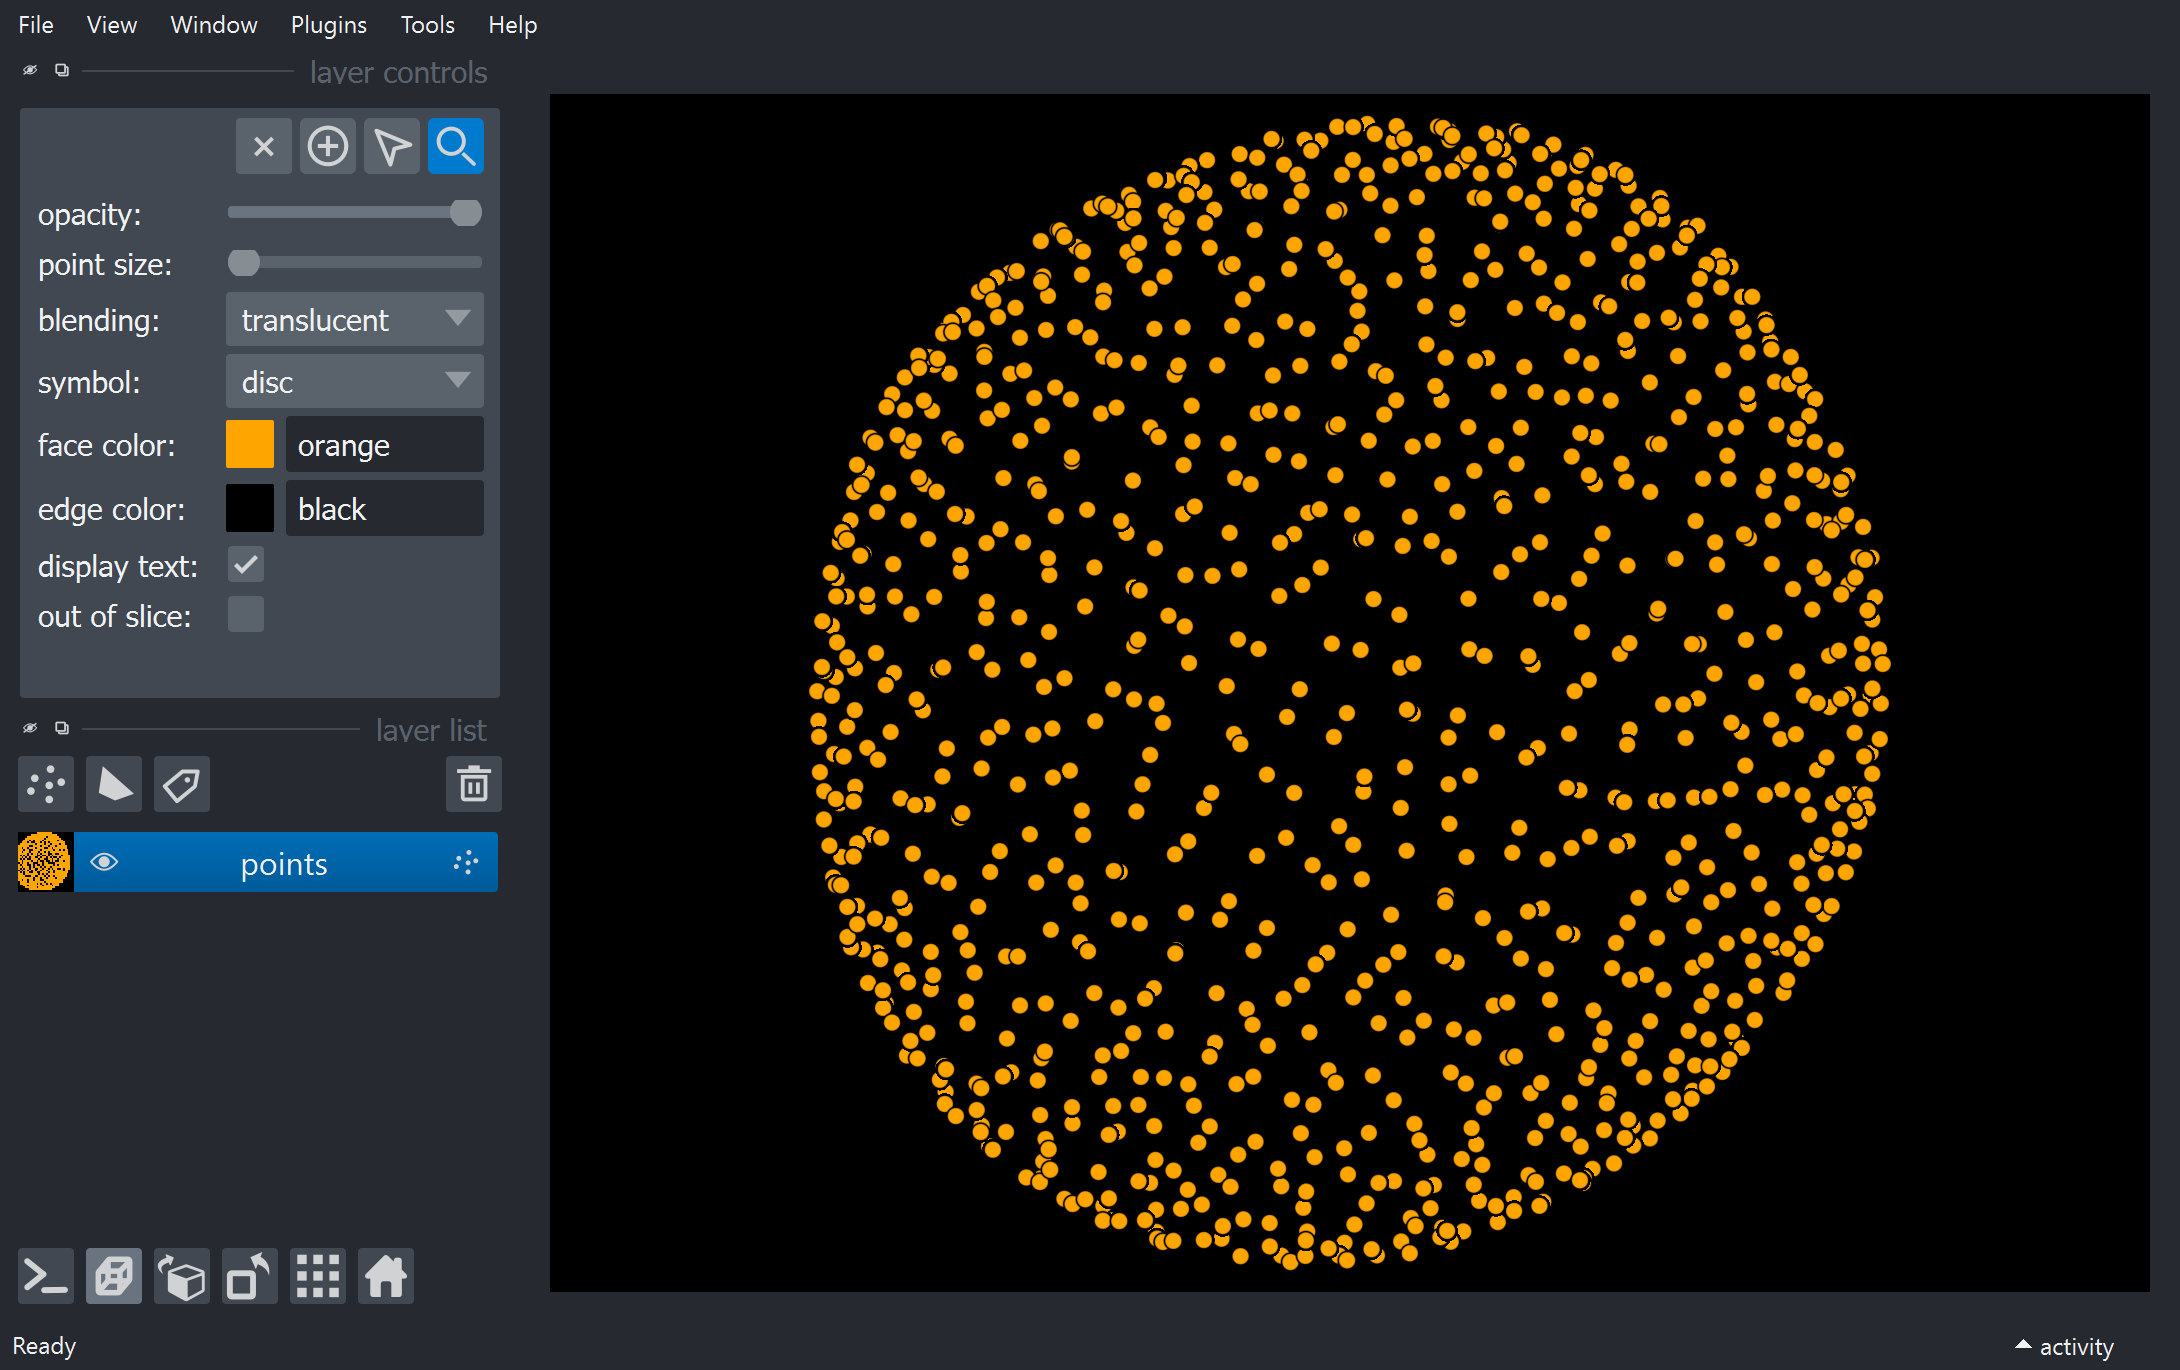

In [4]:
viewer.add_points(points, **properties)
napari.utils.nbscreenshot(viewer)

## Spherical harmonics expansion

First, we need to create a spherical harmonics expansion to be analyzed. The key parameter for this process is the maximal degree of the expansion. In this example, we'll use a maximal degree of `max_degree=10`.

We can do the spherical harmonics expansion with `napari_stress.spherical_harmonics`. The result is a [`LayerDataTuple`](https://napari.org/api/napari.types.html), which consists of the tree entries `(data, properties, "points")`. You'll see that this returns some information on top of the fitted points:

In [5]:
max_degree = 10

In [6]:
result = napari_stress.fit_spherical_harmonics(points, max_degree=max_degree)
properties = result[1]
properties.keys()

dict_keys(['features', 'metadata', 'face_color', 'size'])

### Expansion error

Let's have a look at the `features` and the `metadata`. The `features`, for instance, contains a subfield `error`, which tells us something about the remainder of the spherical harmonics expansion, or - in other words, the remaining distance between the "true" input point and the approximated point location: 

Average fit remainder: 0.034059297379970654 +/- 0.026987189358684924


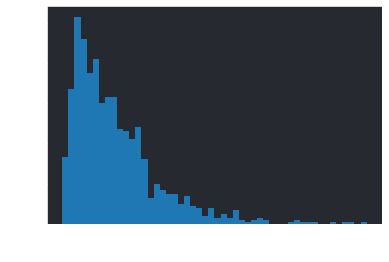

In [7]:
errors = properties['features']['error']

fig, ax = plt.subplots()
hist = ax.hist(errors, bins=50)
ax.set_xlabel('Fit remainder')
ax.set_ylabel('Occurrences [#]')

print(f'Average fit remainder: {errors.mean()} +/- {errors.std()}' ) 

## Mean curvature

Another, highly interesting parameter is given by the `mean_curvature`. For this, we need the two functions `lebedev_quadrature` and `calculate_mean_curvature_on_manifold`. This calculation requires the fit coefficients from the previous step:

In [8]:
coefficients = properties['metadata']['spherical_harmonics_coefficients']

Performing the following calculations in a mathematical exact manner requires the calculation of a minimal number of so-called lebedev quadrature points on the surface of the sperhical harmonics expansion. This minimal number depends on the used `max_degree` of the expansion: More complex expansions requires a higher number of quadrature points. To simply use the minimal number of necessary points, you can use the option `use_minimal_point_set=True`.

If, you want to continue working with a denser pointcloud (e.g., for display reasons), you can disable this option with `use_minimal_point_set=False` and simply set the number of quadrature points yourself any given number with `number_of_quadrature_points=some_number`. If this number is lower than the minimally required value it wil be increased automatically. Also, values beyond 5180 points are not available - chosing point numbers of > 1000 can also lead to significant computation times. 

In [9]:
lebedev_points, LBDV_Fit = napari_stress.lebedev_quadrature(coefficients, number_of_quadrature_points=500, use_minimal_point_set=False)
curvature = napari_stress.calculate_mean_curvature_on_manifold(lebedev_points, lebedev_fit=LBDV_Fit, max_degree=max_degree)

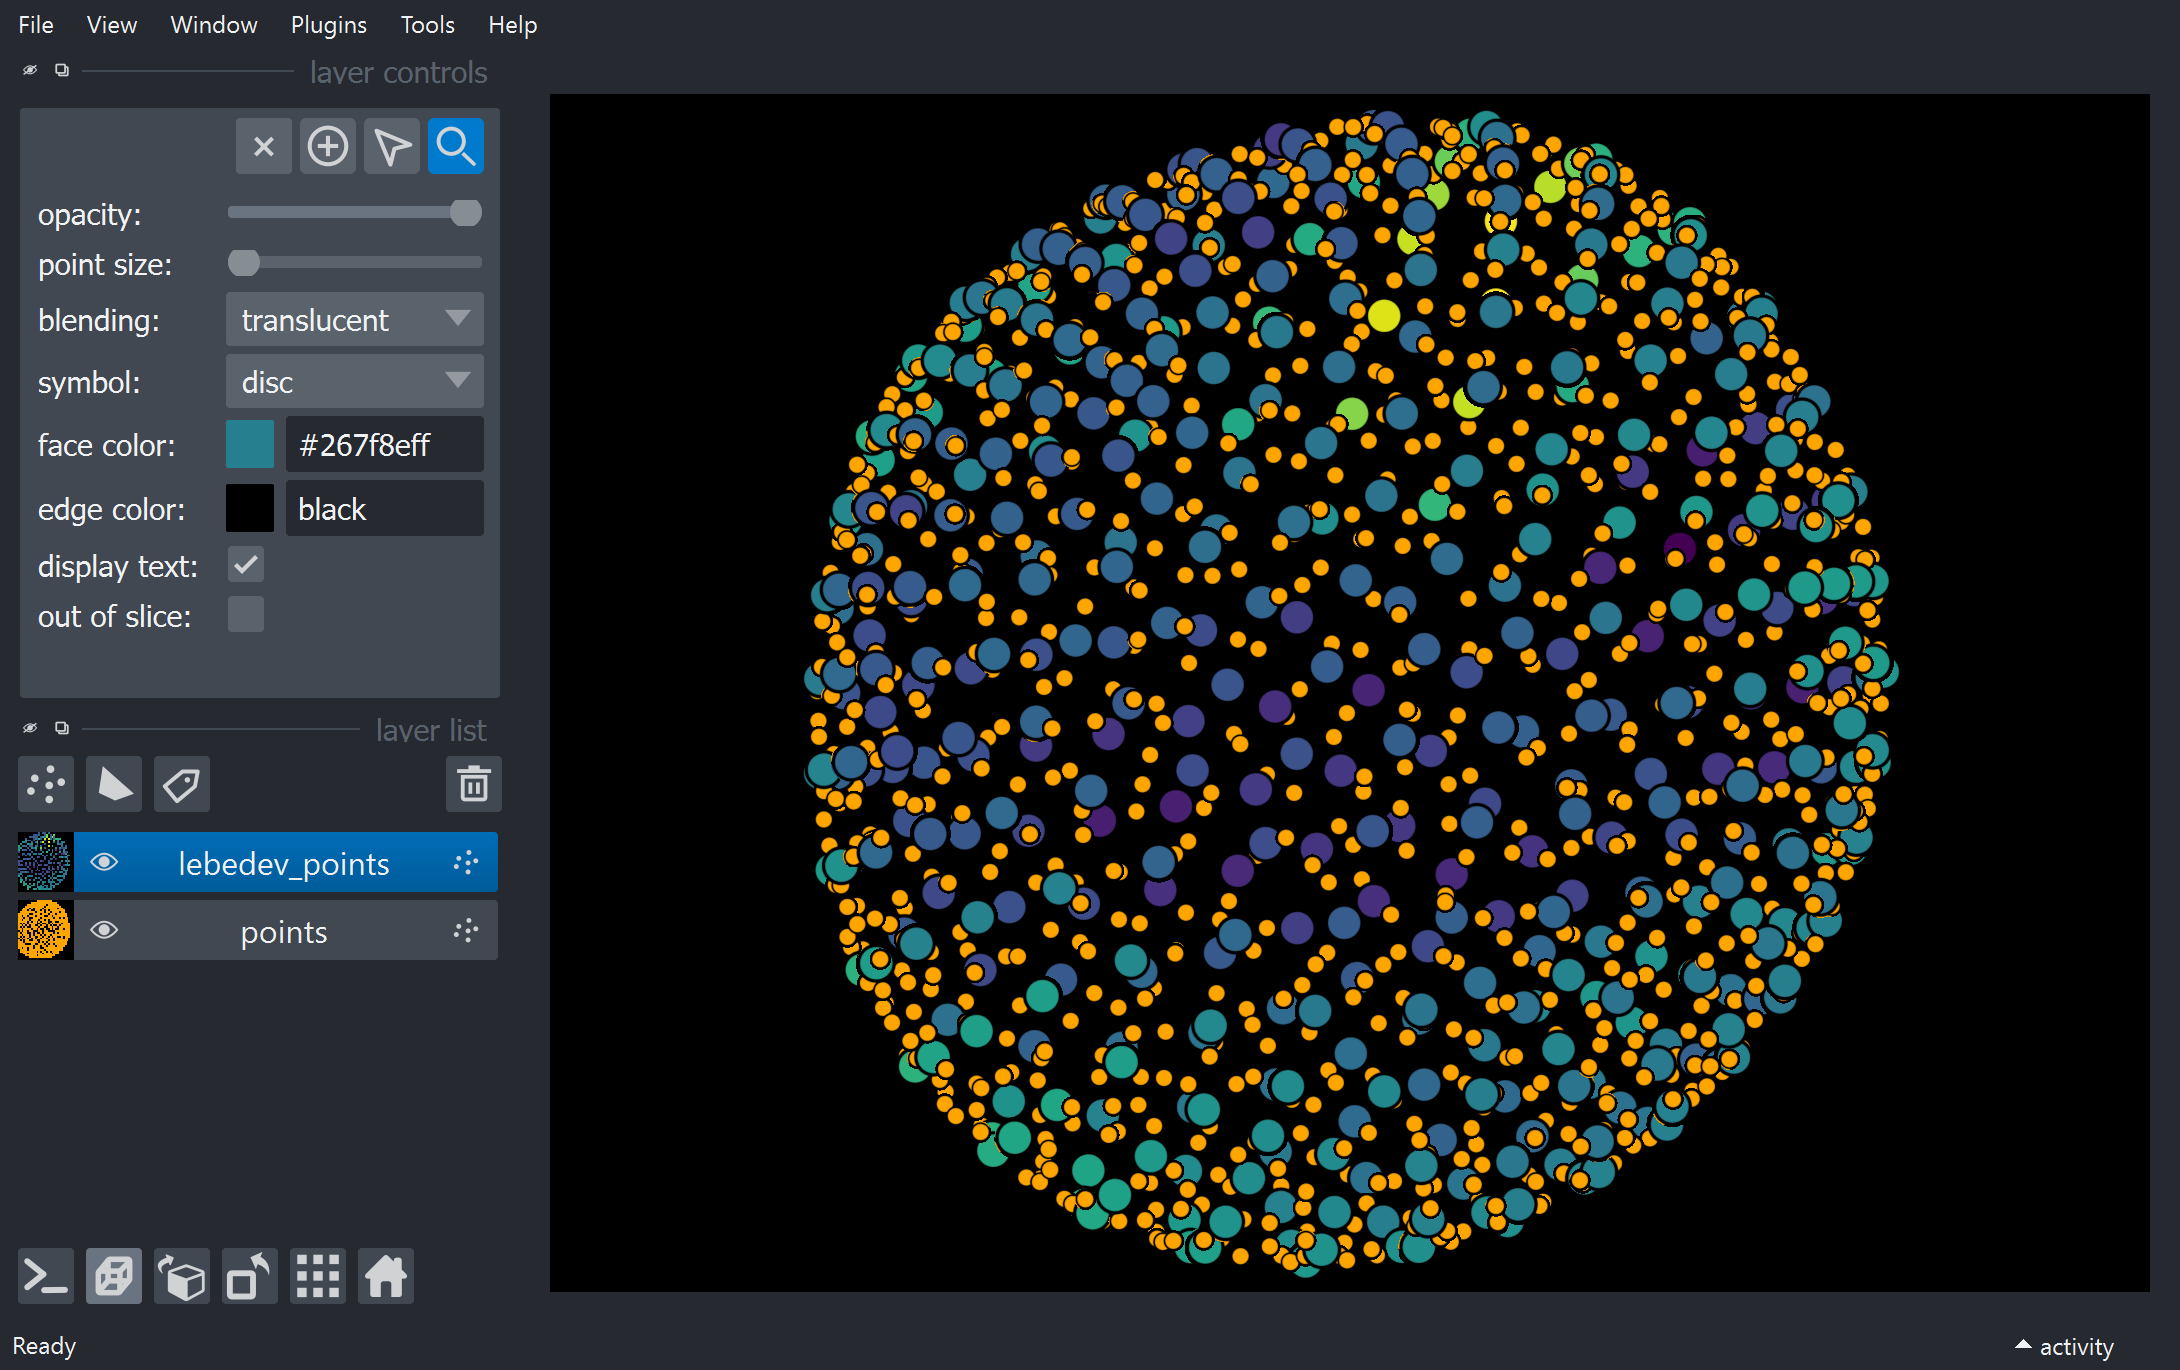

In [10]:
viewer.add_points(lebedev_points, features={'curvature': curvature}, face_color='curvature', size=1)
napari.utils.nbscreenshot(viewer, canvas_only=False)

Again, we can now calculate the curvature histogram as well as average curvatures:

Averaged mean curvature: 0.06499475289776607 +/- 0.01167219352701176


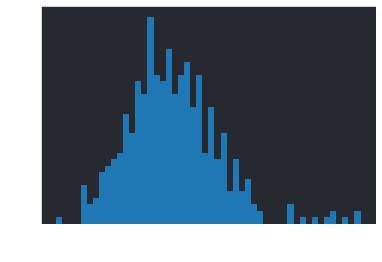

In [11]:
fig, ax = plt.subplots()
hist = ax.hist(curvature, bins=50)
ax.set_xlabel('Curvature')
ax.set_ylabel('Occurrences')
print(f'Averaged mean curvature: {curvature.mean()} +/- {curvature.std()}')